# imports

In [33]:
import pandas as pd
import numpy as np
import sklearn
import pickle 
import time 
import datetime
import warnings
warnings.filterwarnings('ignore')

In [34]:
%run ../function_proposed_gcn.py

In [35]:
with open('../fraudTrain.pkl', 'rb') as file:
    fraudTrain = pickle.load(file)    

In [36]:
fraudTrain.is_fraud.mean()

0.005727773406766326

In [37]:
df50 = throw(fraudTrain,0.5)
df_tr, df_tst = sklearn.model_selection.train_test_split(df50)

dfn = fraudTrain[::10]
dfn = dfn.reset_index(drop=True)
df_trn, df_tstn = sklearn.model_selection.train_test_split(dfn)


In [38]:
df_tr.shape,df_tstn.shape

((9009, 22), (26215, 22))

In [39]:
df2, mask = concat(df_tr, df_tstn)
df2['index'] = df2.index
df = df2.reset_index()

In [40]:
df.is_fraud.mean(), df_tr.is_fraud.mean(), df_tstn.is_fraud.mean()

(0.1329775153304565, 0.5034965034965035, 0.005645622735075339)

In [41]:
groups = df.groupby('cc_num')

In [42]:
# edge_index = np.array([item for sublist in (compute_time_difference(group) for _, group in groups) for item in sublist])
# edge_index = edge_index.astype(np.float64)

In [43]:
# np.save('edge_index_0215.npy', edge_index)

In [44]:
edge_index = np.load('edge_index_0215.npy')

In [45]:
edge_index[:,2].mean()

11424483.3240161

(array([396764., 293276., 254602., 221676., 185488., 142054., 107284.,
         72978.,  32646.,  10480.]),
 array([       0.,  3754074.,  7508148., 11262222., 15016296., 18770370.,
        22524444., 26278518., 30032592., 33786666., 37540740.]),
 <BarContainer object of 10 artists>)

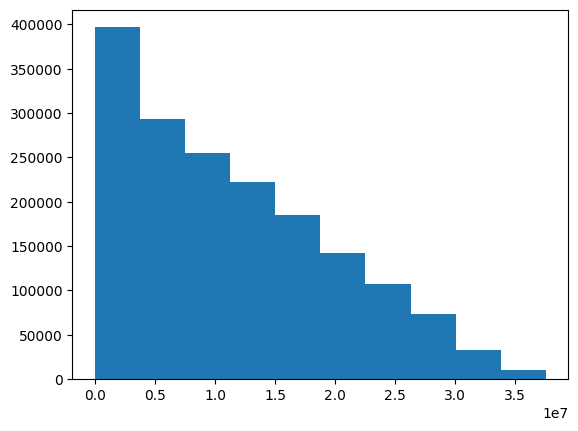

In [46]:
plt.hist(edge_index[:,2])

time의 차이니까...... 값이 작을수록, 거래시간이 가까운것. 

In [47]:
theta = edge_index[:,2].mean()

(array([ 10480.,  32646.,  72978., 107284., 142054., 185488., 221676.,
        254602., 293276., 396764.]),
 array([-3.754074 , -3.3786666, -3.0032592, -2.6278518, -2.2524444,
        -1.877037 , -1.5016296, -1.1262222, -0.7508148, -0.3754074,
        -0.       ]),
 <BarContainer object of 10 artists>)

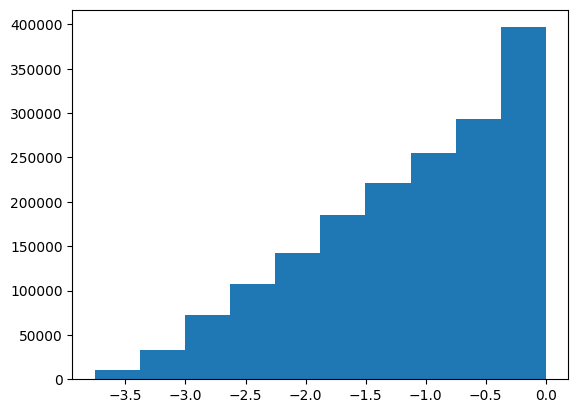

In [48]:
plt.hist(-edge_index[:,2]/1e7)

(array([ 10480.,  32646.,  72978., 107284., 142054., 185488., 221676.,
        254602., 293276., 396764.]),
 array([-3.28599018, -2.95739116, -2.62879214, -2.30019313, -1.97159411,
        -1.64299509, -1.31439607, -0.98579705, -0.65719804, -0.32859902,
        -0.        ]),
 <BarContainer object of 10 artists>)

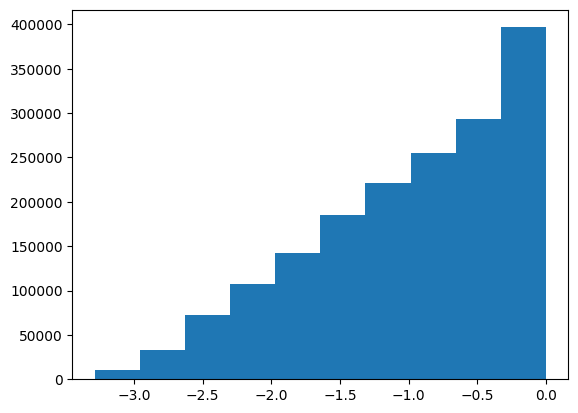

In [49]:
plt.hist(-edge_index[:,2]/theta)

In [50]:
-3.647298e-01

-0.3647298

- 마이너스 하니까 값이 클수록 거래시간이 가까움.

In [51]:
np.percentile(-edge_index[:,2]/theta,75), np.percentile(-edge_index[:,2]/theta,80), np.percentile(-edge_index[:,2]/theta,85), np.percentile(-edge_index[:,2]/theta,90)

(-0.36472984220131965,
 -0.27277732494466095,
 -0.18372121876074105,
 -0.09886661549285204)

In [52]:
(pd.DataFrame(-edge_index[:,2]/1e7)).describe()

,0
count,1.717248e+06
mean,-1.142448e+00
std,8.596337e-01
min,-3.754074e+00
25%,-1.739953e+00
50%,-9.940050e-01
75%,-4.166850e-01
max,-0.000000e+00


In [53]:
(pd.DataFrame(-edge_index[:,2]/theta)).describe()

,0
count,1.717248e+06
mean,-1.000000e+00
std,7.524487e-01
min,-3.285990e+00
25%,-1.523004e+00
50%,-8.700656e-01
75%,-3.647298e-01
max,-0.000000e+00


(array([151332., 266952., 239110., 201528., 174204., 157072., 141056.,
        125410., 117738., 142846.]),
 array([0.        , 0.09999947, 0.19999895, 0.29999842, 0.3999979 ,
        0.49999737, 0.59999685, 0.69999632, 0.7999958 , 0.89999527,
        0.99999475]),
 <BarContainer object of 10 artists>)

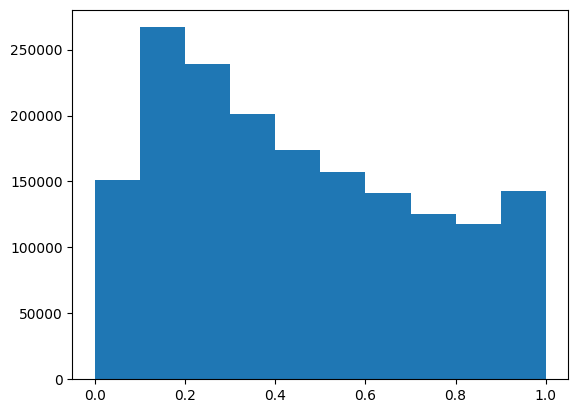

In [54]:
plt.hist((np.exp(-edge_index[:,2]/(theta)) != 1)*(np.exp(-edge_index[:,2]/(theta))).tolist())

In [55]:
pd.DataFrame((np.exp(-edge_index[:,2]/(theta)) != 1)*(np.exp(-edge_index[:,2]/(theta))).tolist()).describe()

,0
count,1.717248e+06
mean,4.457620e-01
std,2.803088e-01
min,0.000000e+00
25%,2.042338e-01
50%,3.998302e-01
75%,6.679522e-01
max,9.999947e-01


In [56]:
edge_index[:,2]  = (np.exp(-edge_index[:,2]/(theta)) != 1)*(np.exp(-edge_index[:,2]/(theta))).tolist()

In [57]:
edge_index = torch.tensor([(int(row[0]), int(row[1])) for row in edge_index if row[2] > 0.8], dtype=torch.long).t()

In [59]:
x = torch.tensor(df['amt'].values, dtype=torch.float).reshape(-1,1)
y = torch.tensor(df['is_fraud'].values,dtype=torch.int64)
data = torch_geometric.data.Data(x=x, edge_index = edge_index, y=y, train_mask = mask[0], test_mask= mask[1])


In [60]:
data

Data(x=[35224, 1], edge_index=[2, 260578], y=[35224], train_mask=[35224], test_mask=[35224])

In [61]:
model = GCN1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
yy = (data.y[data.test_mask]).numpy()
yyhat, yyhat_ = train_and_evaluate_model(data, model, optimizer)
yyhat_ = yyhat_.detach().numpy()
eval = evaluation(yy, yyhat, yyhat_)

In [62]:
eval

{'acc': 0.8473393095555979,
 'pre': 0.018009004502251125,
 'rec': 0.4864864864864865,
 'f1': 0.03473227206946455,
 'auc': 0.7499672102762216}

?!?!?